# Import Libraries

In [1]:
import os
import json
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import xgboost as xgb
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import pmdarima as pm
import warnings
warnings.filterwarnings("ignore")
#import tensorflow as tf
#from tensorflow.keras import layers

In [2]:
%matplotlib inline

# Data - Preprocessing and EDA

In [3]:
folder_path = "./Jan2022Jul2023/"

json_files = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith(".json")]
data_list = []

for file in json_files:
    with open(file, "r") as f:
        data_list.extend(json.load(f))

In [4]:
df = pd.DataFrame(data_list)

In [ ]:
#df.to_csv('Data.csv')

In [5]:
df["startTime"] = pd.to_datetime(df["startTime"])
df["endTime"] = pd.to_datetime(df["endTime"])

In [6]:
type(df["startTime"])

pandas.core.series.Series

In [7]:
# Set "startTime" as the index to create time series data
df.set_index("startTime", inplace=True)

In [8]:
df_demand_15 = df["tripId"].resample("15T").count()
df_demand_30 = df["tripId"].resample("30T").count()
df_demand_45 = df["tripId"].resample("45T").count()
df_demand_60 = df["tripId"].resample("60T").count()
df_demand_1_day = df["tripId"].resample("1D").count()
df_demand_7_days = df["tripId"].resample("7D").count()

In [9]:
interval_15 = pd.DataFrame(df_demand_15)
interval_30 = pd.DataFrame(df_demand_30)
interval_45 = pd.DataFrame(df_demand_45)
interval_60 = pd.DataFrame(df_demand_60)
interval_1_day = pd.DataFrame(df_demand_1_day)
interval_7_days = pd.DataFrame(df_demand_7_days)

In [10]:
filtered_data_15 = interval_15
use_this_15 = filtered_data_15

filtered_data_1_day = interval_1_day
use_this_1_day = filtered_data_1_day

In [11]:
use_this_15

,tripId
startTime,
2022-01-01 06:30:00,1
2022-01-01 06:45:00,1
2022-01-01 07:00:00,0
2022-01-01 07:15:00,0
2022-01-01 07:30:00,1
...,...
2023-08-01 07:45:00,2
2023-08-01 08:00:00,4
2023-08-01 08:15:00,9


In [12]:
interval_1_day

,tripId
startTime,
2022-01-01,116
2022-01-02,155
2022-01-03,163
2022-01-04,143
2022-01-05,160
...,...
2023-07-28,243
2023-07-29,229
2023-07-30,229


# For 15 Min intervals

<AxesSubplot:xlabel='startTime', ylabel='tripId'>

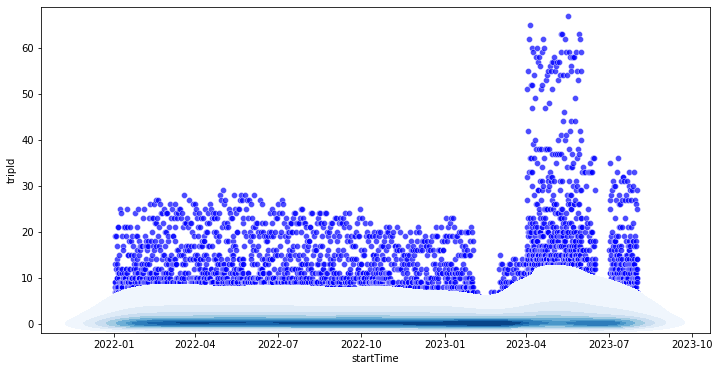

In [13]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=interval_15, x='startTime', y='tripId', alpha=0.7, color='blue')
sns.kdeplot(data=interval_15, x='startTime', y='tripId', cmap='Blues', fill=True)

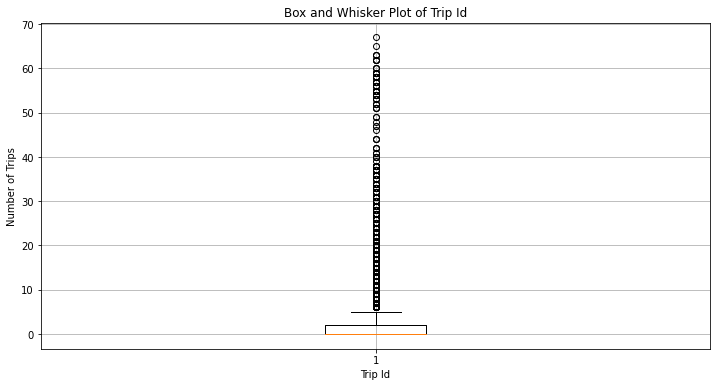

In [14]:
plt.figure(figsize=(12, 6))
plt.boxplot(filtered_data_15['tripId'])
plt.xlabel("Trip Id")
plt.ylabel("Number of Trips")
plt.title("Box and Whisker Plot of Trip Id")
plt.grid(True)
plt.show()

# For 1 day Intervals

<AxesSubplot:xlabel='startTime', ylabel='tripId'>

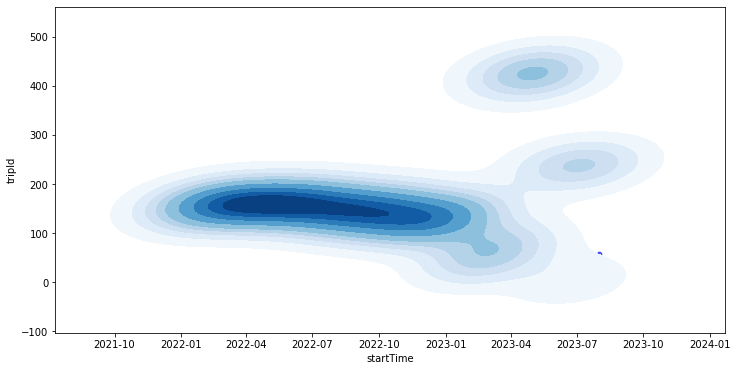

In [15]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=interval_1_day, x='startTime', y='tripId', alpha=0.7, color='blue')
sns.kdeplot(data=interval_1_day, x='startTime', y='tripId', cmap='Blues', fill=True)

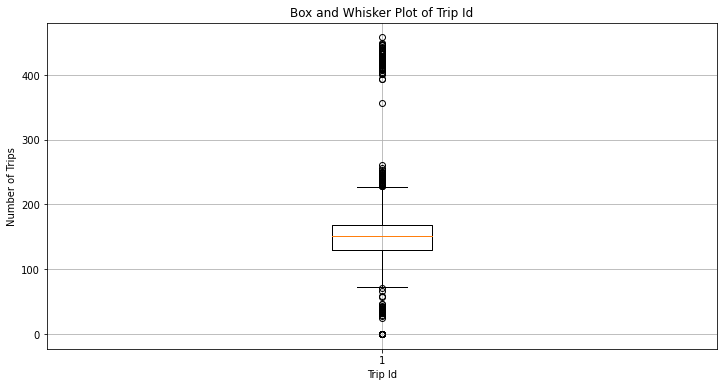

In [16]:
plt.figure(figsize=(12, 6))
plt.boxplot(filtered_data_1_day['tripId'])
plt.xlabel("Trip Id")
plt.ylabel("Number of Trips")
plt.title("Box and Whisker Plot of Trip Id")
plt.grid(True)
plt.show()

In [17]:
filtered_data_15 = use_this_15
filtered_data_1_day = use_this_1_day

# Creating and Evaluating different models
```1) Linear Regression
 2) XGBoost Regression
 3) ARIMA Model
 4) AutoARIMA Model```

# Linear Regression

***for 15Min Intervals***

Linear Regression - 
MAE: 1.4132112276132556
RMSE: 1.692738319852964


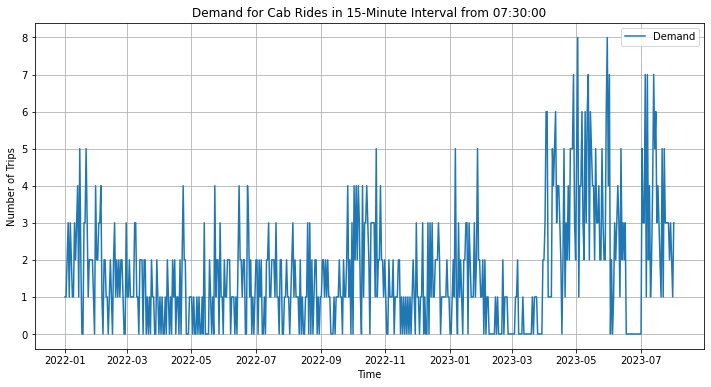

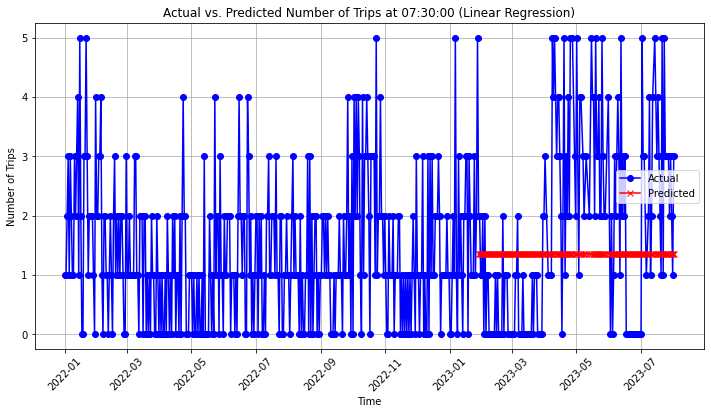

In [18]:
input_timestamp = '07:30:00'

# Extract the tripId values corresponding to the input timestamp
filtered_data_15 = interval_15.loc[interval_15.index.time == pd.to_datetime(input_timestamp).time()]

# Plotting filtered data
plt.figure(figsize=(12, 6))
plt.plot(filtered_data_15.index, filtered_data_15['tripId'], label="Demand")
plt.xlabel("Time")
plt.ylabel("Number of Trips")
plt.title(f"Demand for Cab Rides in 15-Minute Interval from {input_timestamp}")
plt.legend()
plt.grid(True) 

# Remove outliers using the IQR method
Q1 = filtered_data_15['tripId'].quantile(0.25)
Q3 = filtered_data_15['tripId'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
filtered_data_15 = filtered_data_15[(filtered_data_15['tripId'] >= lower_bound) & (filtered_data_15['tripId'] <= upper_bound)]

# Split the data into train and test sets
train_data_15, test_data_15 = train_test_split(filtered_data_15, test_size=0.3, shuffle=False)

# Creating regression model
regression_model_15 = LinearRegression()
regression_model_15.fit(np.arange(len(train_data_15)).reshape(-1, 1), train_data_15)

# Make predictions, calculate metrics
regression_preds_15 = regression_model_15.predict(np.arange(len(test_data_15)).reshape(-1, 1))
mae_regressor_15 = mean_absolute_error(test_data_15, regression_preds_15)
rmse_regressor_15 = np.sqrt(mean_squared_error(test_data_15, regression_preds_15))
r2_regressor_15 = r2_score(test_data_15, regression_preds_15)

print(f"Linear Regression - \nMAE: {mae_regressor_15}\nRMSE: {rmse_regressor_15}")

# Plot actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(filtered_data_15.index, filtered_data_15['tripId'], color='blue', label='Actual', linestyle='-', marker='o')
plt.plot(test_data_15.index, regression_preds_15, color='red', label='Predicted', linestyle='-', marker='x')
plt.xlabel("Time")
plt.ylabel("Number of Trips")
plt.title(f"Actual vs. Predicted Number of Trips at {input_timestamp} (Linear Regression)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

***For 1 Day Intervals***

Linear Regression for 1-Day Interval - 
MAE: 42.60134686382462
RMSE: 48.54152596821054


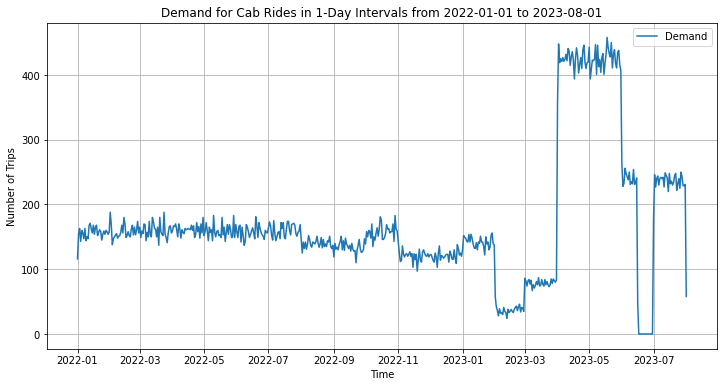

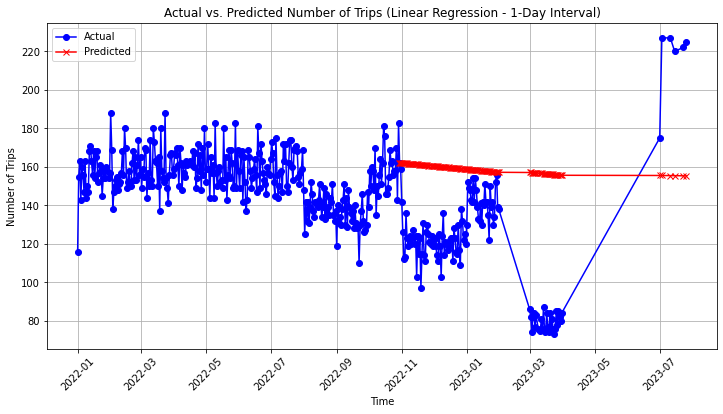

In [19]:
start_date = '2022-01-01'
end_date = '2023-08-01'

filtered_data_1_day = interval_1_day[start_date:end_date]

plt.figure(figsize=(12, 6))
plt.plot(filtered_data_1_day.index, filtered_data_1_day['tripId'], label="Demand")
plt.xlabel("Time")
plt.ylabel("Number of Trips")
plt.title(f"Demand for Cab Rides in 1-Day Intervals from {start_date} to {end_date}")
plt.legend()
plt.grid(True) 

Q1_1_day = filtered_data_1_day['tripId'].quantile(0.25)
Q3_1_day = filtered_data_1_day['tripId'].quantile(0.75)
IQR_1_day = Q3_1_day - Q1_1_day
lower_bound_1_day = Q1_1_day - 1.5 * IQR_1_day
upper_bound_1_day = Q3_1_day + 1.5 * IQR_1_day
filtered_data_1_day = filtered_data_1_day[(filtered_data_1_day['tripId'] >= lower_bound_1_day) & (filtered_data_1_day['tripId'] <= upper_bound_1_day)]


train_data_1_day, test_data_1_day = train_test_split(filtered_data_1_day, test_size=0.3, shuffle=False)

regression_model_1_day = LinearRegression()
regression_model_1_day.fit(np.arange(len(train_data_1_day)).reshape(-1, 1), train_data_1_day)

regression_preds_1_day = regression_model_1_day.predict(np.arange(len(test_data_1_day)).reshape(-1, 1))
mae_regressor_1_day = mean_absolute_error(test_data_1_day, regression_preds_1_day)
rmse_regressor_1_day = np.sqrt(mean_squared_error(test_data_1_day, regression_preds_1_day))
r2_regressor_1_day = r2_score(test_data_1_day, regression_preds_1_day)

print(f"Linear Regression for 1-Day Interval - \nMAE: {mae_regressor_1_day}\nRMSE: {rmse_regressor_1_day}")

plt.figure(figsize=(12, 6))
plt.plot(filtered_data_1_day.index, filtered_data_1_day['tripId'], color='blue', label='Actual', linestyle='-', marker='o')
plt.plot(test_data_1_day.index, regression_preds_1_day, color='red', label='Predicted', linestyle='-', marker='x')
plt.xlabel("Time")
plt.ylabel("Number of Trips")
plt.title(f"Actual vs. Predicted Number of Trips (Linear Regression - 1-Day Interval)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


In [20]:
filtered_data_15 = use_this_15
filtered_data_1_day = use_this_1_day

# XGBRegressor

***for 15 Min Intervals***

XGBoost Regression - 
MAE: 1.7200446610708209
RMSE: 2.139986121839804


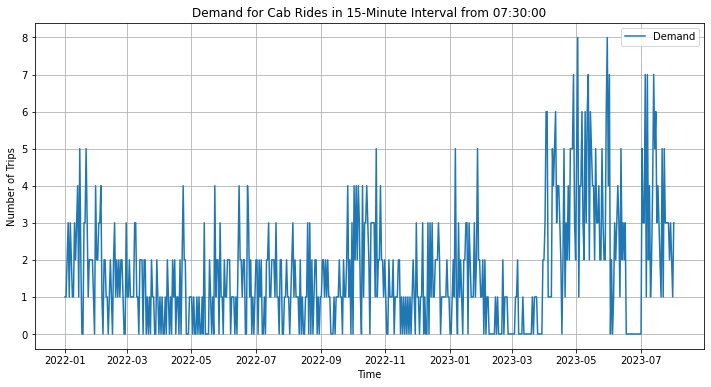

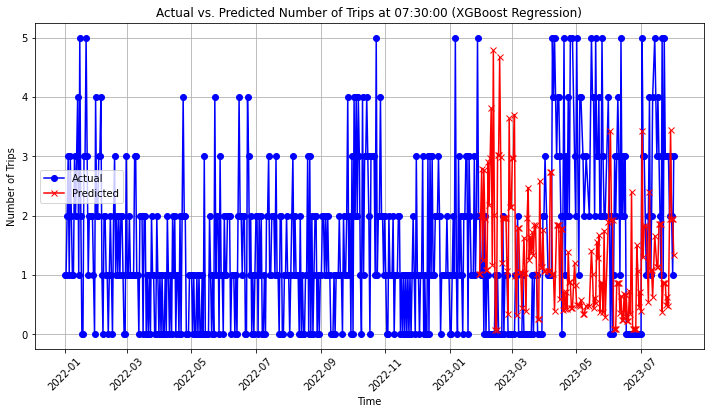

In [21]:
input_timestamp = '07:30:00'

filtered_data_15 = interval_15.loc[interval_15.index.time == pd.to_datetime(input_timestamp).time()]

plt.figure(figsize=(12, 6))
plt.plot(filtered_data_15.index, filtered_data_15['tripId'], label="Demand")
plt.xlabel("Time")
plt.ylabel("Number of Trips")
plt.title(f"Demand for Cab Rides in 15-Minute Interval from {input_timestamp}")
plt.legend()
plt.grid(True) 

Q1 = filtered_data_15['tripId'].quantile(0.25)
Q3 = filtered_data_15['tripId'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
filtered_data_15 = filtered_data_15[(filtered_data_15['tripId'] >= lower_bound) & (filtered_data_15['tripId'] <= upper_bound)]

train_data_15, test_data_15 = train_test_split(filtered_data_15, test_size=0.3, shuffle=False)

xgb_model = xgb.XGBRegressor()
xgb_model.fit(np.arange(len(train_data_15)).reshape(-1, 1), train_data_15['tripId'])

xgb_preds_15 = xgb_model.predict(np.arange(len(test_data_15)).reshape(-1, 1))
mae_xgb_15 = mean_absolute_error(test_data_15['tripId'], xgb_preds_15)
rmse_xgb_15 = np.sqrt(mean_squared_error(test_data_15['tripId'], xgb_preds_15))
r2_xgb_15 = r2_score(test_data_15['tripId'], xgb_preds_15)

print(f"XGBoost Regression - \nMAE: {mae_xgb_15}\nRMSE: {rmse_xgb_15}")

plt.figure(figsize=(12, 6))
plt.plot(filtered_data_15.index, filtered_data_15['tripId'], color='blue', label='Actual', linestyle='-', marker='o')
plt.plot(test_data_15.index, xgb_preds_15, color='red', label='Predicted', linestyle='-', marker='x')
plt.xlabel("Time")
plt.ylabel("Number of Trips")
plt.title(f"Actual vs. Predicted Number of Trips at {input_timestamp} (XGBoost Regression)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


***for 1 Day Intervals***

XGBoost Regression for 1-Day Interval - 
MAE: 43.28072216327374
RMSE: 50.06154732974351


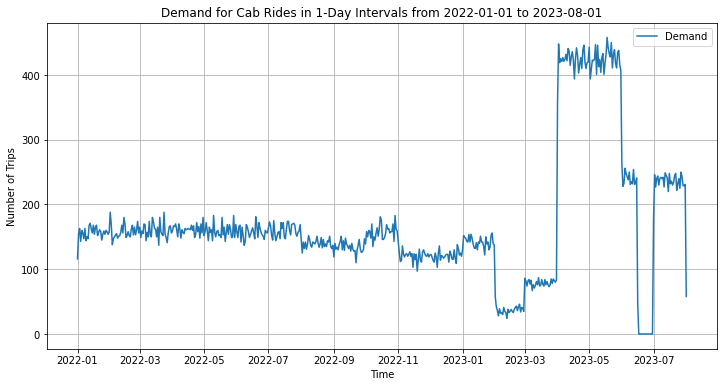

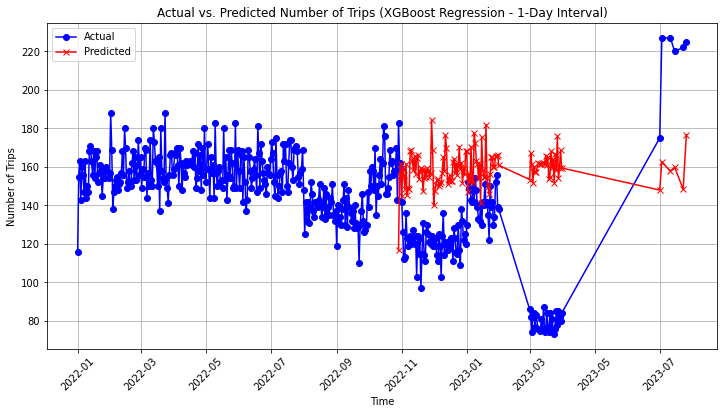

In [22]:
start_date = '2022-01-01'
end_date = '2023-08-01'

filtered_data_1_day = interval_1_day[start_date:end_date].resample('1D').sum()

plt.figure(figsize=(12, 6))
plt.plot(filtered_data_1_day.index, filtered_data_1_day['tripId'], label="Demand")
plt.xlabel("Time")
plt.ylabel("Number of Trips")
plt.title(f"Demand for Cab Rides in 1-Day Intervals from {start_date} to {end_date}")
plt.legend()
plt.grid(True) 

Q1_1_day = filtered_data_1_day['tripId'].quantile(0.25)
Q3_1_day = filtered_data_1_day['tripId'].quantile(0.75)
IQR_1_day = Q3_1_day - Q1_1_day
lower_bound_1_day = Q1_1_day - 1.5 * IQR_1_day
upper_bound_1_day = Q3_1_day + 1.5 * IQR_1_day
filtered_data_1_day = filtered_data_1_day[(filtered_data_1_day['tripId'] >= lower_bound_1_day) & (filtered_data_1_day['tripId'] <= upper_bound_1_day)]

train_data_1_day, test_data_1_day = train_test_split(filtered_data_1_day, test_size=0.3, shuffle=False)

xgb_model_1_day = xgb.XGBRegressor()
xgb_model_1_day.fit(np.arange(len(train_data_1_day)).reshape(-1, 1), train_data_1_day['tripId'])

xgb_preds_1_day = xgb_model_1_day.predict(np.arange(len(test_data_1_day)).reshape(-1, 1))
mae_xgb_1_day = mean_absolute_error(test_data_1_day['tripId'], xgb_preds_1_day)
rmse_xgb_1_day = np.sqrt(mean_squared_error(test_data_1_day['tripId'], xgb_preds_1_day))
r2_xgb_1_day = r2_score(test_data_1_day['tripId'], xgb_preds_1_day)

print(f"XGBoost Regression for 1-Day Interval - \nMAE: {mae_xgb_1_day}\nRMSE: {rmse_xgb_1_day}")

plt.figure(figsize=(12, 6))
plt.plot(filtered_data_1_day.index, filtered_data_1_day['tripId'], color='blue', label='Actual', linestyle='-', marker='o')
plt.plot(test_data_1_day.index, xgb_preds_1_day, color='red', label='Predicted', linestyle='-', marker='x')
plt.xlabel("Time")
plt.ylabel("Number of Trips")
plt.title(f"Actual vs. Predicted Number of Trips (XGBoost Regression - 1-Day Interval)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


In [23]:
filtered_data_15 = use_this_15
filtered_data_1_day = use_this_1_day

# ARIMA Prediction

***for 15Min Intervals***

ARIMA Regression - 
MAE: 2.069671393681674
RMSE: 2.3701649460944165


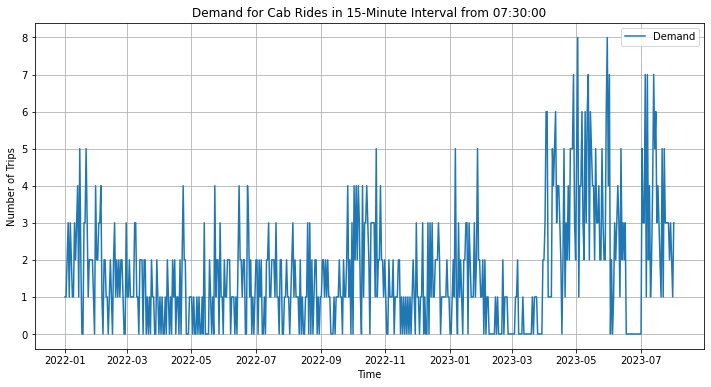

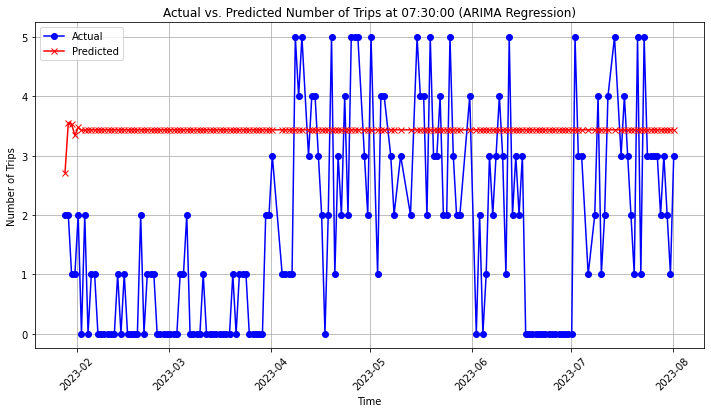

In [24]:
input_timestamp = '07:30:00'

filtered_data_15 = interval_15.loc[interval_15.index.time == pd.to_datetime(input_timestamp).time()]

plt.figure(figsize=(12, 6))
plt.plot(filtered_data_15.index, filtered_data_15['tripId'], label="Demand")
plt.xlabel("Time")
plt.ylabel("Number of Trips")
plt.title(f"Demand for Cab Rides in 15-Minute Interval from {input_timestamp}")
plt.legend()
plt.grid(True) 

Q1 = filtered_data_15['tripId'].quantile(0.25)
Q3 = filtered_data_15['tripId'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
filtered_data_15 = filtered_data_15[(filtered_data_15['tripId'] >= lower_bound) & (filtered_data_15['tripId'] <= upper_bound)]

train_data_15, test_data_15 = train_test_split(filtered_data_15, test_size=0.3, shuffle=False)

order = (2, 1, 0)  
arima_model = sm.tsa.ARIMA(train_data_15['tripId'], order=order)
arima_model_fit = arima_model.fit()

arima_preds_15 = arima_model_fit.forecast(steps=len(test_data_15))
mae_arima_15 = mean_absolute_error(test_data_15['tripId'], arima_preds_15)
rmse_arima_15 = np.sqrt(mean_squared_error(test_data_15['tripId'], arima_preds_15))
r2_arima_15 = r2_score(test_data_15['tripId'], arima_preds_15)

print(f"ARIMA Regression - \nMAE: {mae_arima_15}\nRMSE: {rmse_arima_15}")

plt.figure(figsize=(12, 6))
plt.plot(test_data_15.index, test_data_15['tripId'], color='blue', label='Actual', linestyle='-', marker='o')
plt.plot(test_data_15.index, arima_preds_15, color='red', label='Predicted', linestyle='-', marker='x')
plt.xlabel("Time")
plt.ylabel("Number of Trips")
plt.title(f"Actual vs. Predicted Number of Trips at {input_timestamp} (ARIMA Regression)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


***For 1 Day Interval***

ARIMA Regression for 1-Day Interval - 
MAE: 38.347631658260575
RMSE: 45.18459721539759


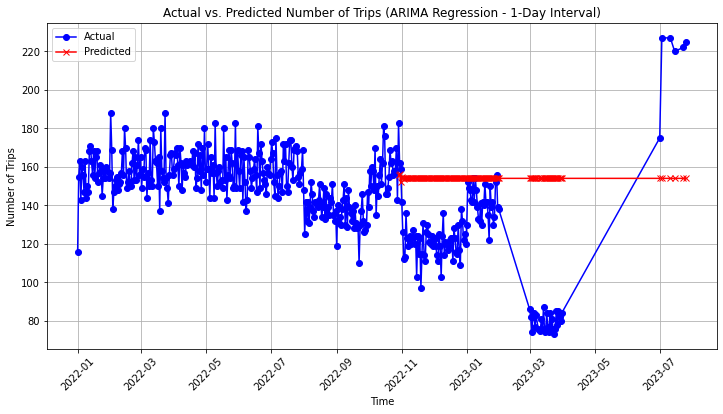

In [25]:
start_date = '2022-01-01'
end_date = '2023-08-01'

filtered_data_1_day = interval_1_day[start_date:end_date].resample('1D').sum()

Q1_1_day = filtered_data_1_day['tripId'].quantile(0.25)
Q3_1_day = filtered_data_1_day['tripId'].quantile(0.75)
IQR_1_day = Q3_1_day - Q1_1_day
lower_bound_1_day = Q1_1_day - 1.5 * IQR_1_day
upper_bound_1_day = Q3_1_day + 1.5 * IQR_1_day
filtered_data_1_day = filtered_data_1_day[(filtered_data_1_day['tripId'] >= lower_bound_1_day) & (filtered_data_1_day['tripId'] <= upper_bound_1_day)]

train_data_1_day, test_data_1_day = train_test_split(filtered_data_1_day, test_size=0.3, shuffle=False)

order = (2, 1, 0)  
arima_model_1_day = sm.tsa.ARIMA(train_data_1_day['tripId'], order=order)
arima_model_fit_1_day = arima_model_1_day.fit()

arima_preds_1_day = arima_model_fit_1_day.forecast(steps=len(test_data_1_day))
mae_arima_1_day = mean_absolute_error(test_data_1_day['tripId'], arima_preds_1_day)
rmse_arima_1_day = np.sqrt(mean_squared_error(test_data_1_day['tripId'], arima_preds_1_day))
r2_arima_1_day = r2_score(test_data_1_day['tripId'], arima_preds_1_day)

print(f"ARIMA Regression for 1-Day Interval - \nMAE: {mae_arima_1_day}\nRMSE: {rmse_arima_1_day}")

plt.figure(figsize=(12, 6))
plt.plot(filtered_data_1_day.index, filtered_data_1_day['tripId'], color='blue', label='Actual', linestyle='-', marker='o')
plt.plot(test_data_1_day.index, arima_preds_1_day, color='red', label='Predicted', linestyle='-', marker='x')
plt.xlabel("Time")
plt.ylabel("Number of Trips")
plt.title(f"Actual vs. Predicted Number of Trips (ARIMA Regression - 1-Day Interval)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


In [26]:
filtered_data_15 = use_this_15
filtered_data_1_day = use_this_1_day

# AutoARIMA

***For 15 Min Interval***

ARIMA Regression - 
MAE: 1.4494753491967507
RMSE: 1.710019640132166


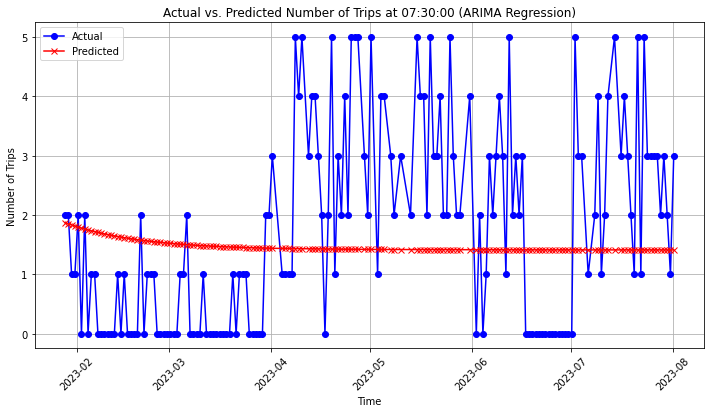

In [27]:
input_timestamp = '07:30:00'
filtered_data_15 = interval_15.loc[interval_15.index.time == pd.to_datetime(input_timestamp).time()]

Q1 = filtered_data_15['tripId'].quantile(0.25)
Q3 = filtered_data_15['tripId'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
filtered_data_15 = filtered_data_15[(filtered_data_15['tripId'] >= lower_bound) & (filtered_data_15['tripId'] <= upper_bound)]

train_data_15, test_data_15 = train_test_split(filtered_data_15, test_size=0.3, shuffle=False)

arima_model = pm.auto_arima(train_data_15['tripId'], seasonal=False, stepwise=True)

arima_preds_15 = arima_model.predict(len(test_data_15))
mae_arima_15 = mean_absolute_error(test_data_15['tripId'], arima_preds_15)
rmse_arima_15 = np.sqrt(mean_squared_error(test_data_15['tripId'], arima_preds_15))
r2_arima_15 = r2_score(test_data_15['tripId'], arima_preds_15)

print(f"ARIMA Regression - \nMAE: {mae_arima_15}\nRMSE: {rmse_arima_15}")

plt.figure(figsize=(12, 6))
plt.plot(test_data_15.index, test_data_15['tripId'], color='blue', label='Actual', linestyle='-', marker='o')
plt.plot(test_data_15.index, arima_preds_15, color='red', label='Predicted', linestyle='-', marker='x')
plt.xlabel("Time")
plt.ylabel("Number of Trips")
plt.title(f"Actual vs. Predicted Number of Trips at {input_timestamp} (ARIMA Regression)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


***For 1 Day Interval***

ARIMA Regression for 1-Day Interval - 
MAE: 41.22551619543978
RMSE: 47.62974155172299


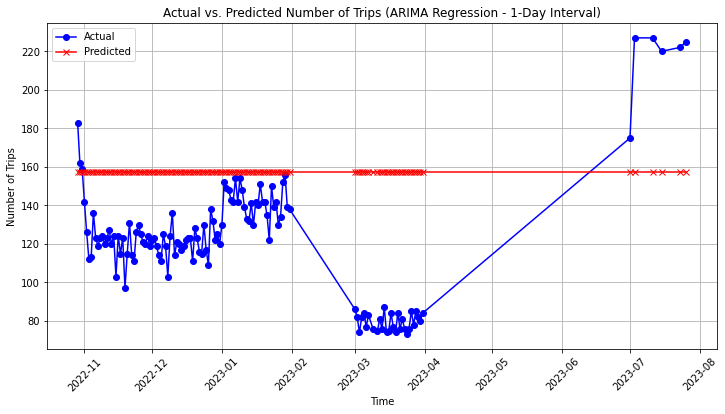

In [28]:
import pmdarima as pm

start_date = '2022-01-01'
end_date = '2023-08-01'

filtered_data_1_day = interval_1_day[start_date:end_date].resample('1D').sum()

Q1_1_day = filtered_data_1_day['tripId'].quantile(0.25)
Q3_1_day = filtered_data_1_day['tripId'].quantile(0.75)
IQR_1_day = Q3_1_day - Q1_1_day
lower_bound_1_day = Q1_1_day - 1.5 * IQR_1_day
upper_bound_1_day = Q3_1_day + 1.5 * IQR_1_day
filtered_data_1_day = filtered_data_1_day[(filtered_data_1_day['tripId'] >= lower_bound_1_day) & (filtered_data_1_day['tripId'] <= upper_bound_1_day)]

train_data_1_day, test_data_1_day = train_test_split(filtered_data_1_day, test_size=0.3, shuffle=False)

arima_model_1_day = pm.auto_arima(train_data_1_day['tripId'], seasonal=False, stepwise=True)

arima_preds_1_day = arima_model_1_day.predict(len(test_data_1_day))
mae_arima_1_day = mean_absolute_error(test_data_1_day['tripId'], arima_preds_1_day)
rmse_arima_1_day = np.sqrt(mean_squared_error(test_data_1_day['tripId'], arima_preds_1_day))
r2_arima_1_day = r2_score(test_data_1_day['tripId'], arima_preds_1_day)

print(f"ARIMA Regression for 1-Day Interval - \nMAE: {mae_arima_1_day}\nRMSE: {rmse_arima_1_day}")

plt.figure(figsize=(12, 6))
plt.plot(test_data_1_day.index, test_data_1_day['tripId'], color='blue', label='Actual', linestyle='-', marker='o')
plt.plot(test_data_1_day.index, arima_preds_1_day, color='red', label='Predicted', linestyle='-', marker='x')
plt.xlabel("Time")
plt.ylabel("Number of Trips")
plt.title(f"Actual vs. Predicted Number of Trips (ARIMA Regression - 1-Day Interval)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


In [ ]:
#season_1_2023 = interval_15["2023-01-01":"2023-03-31"]
#season_2_2023 = interval_15["2023-04-01":"2023-06-30"]
#season_3_2023 = interval_15["2023-07-01":"2023-12-31"]

# Conclusion

In this analysis, I have explored the demand for cab rides in 15-minute and 1-day intervals using the given dataset. Four different regression models were applied to predict the number of trips, and their performance was evaluated using MAE and RMSE metrics.

The four models used are:
1. Linear Regression
2. XGBoost Regression
3. ARIMA (AutoRegressive Integrated Moving Average) Regression
4. AutoARIMA

After analyzing the results and visualizing the predictions, it is evident that XGBoost Regression stands out among the models. Although it may not provide pinpoint accuracy, it demonstrates a better ability to capture the underlying trend in the data compared to the other algorithms.

The XGBoost Regression model consistently outperforms the other models in terms of prediction accuracy and general trend identification. This indicates that XGBoost is the most suitable model for predicting the number of trips in both 15-minute and 1-day intervals.

However, it is essential to consider that the performance of these models may vary based on the dataset and problem at hand. Further experimentation and hyperparameter tuning could potentially lead to even better results.

In conclusion, for the demand prediction of cab rides based on this analysis, XGBoost Regression is recommended as it provides the best overall performance in capturing the trend, even though it may not be the most accurate in individual predictions.
